In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark.pandas as ps
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.ml import Transformer
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
import phik
import numpy as np
import seaborn as sns
import os
import sys

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
columns = list(df.columns)

In [7]:
spark = (SparkSession
         .builder
         .appName('Linreg')
         .master("local")
         .config("spark.executor.memory", "6g") \
         .config("spark.driver.memory", "4g") \
         .config("spark.executor.cores", "8") \
         .getOrCreate())

In [8]:
data = spark.read.load('housing.csv',format='csv',inferSchema = True,header= 'true')

In [9]:
data.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

In [10]:
data.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [11]:
data.select([F.count(F.when(F.isnan(c),c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [12]:
data.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [13]:
data.select([F.count(F.when(F.col(c).isNotNull(),c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|    20640|   20640|             20640|      20640|         20433|     20640|     20640|        20640|             20640|          20640|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Всего 207 Null в total_bedrooms. Это не является пробелмой, могут быть дома без спален, почему нет?)

In [14]:
def fill_missing_values(df, input_cols):
    imputer = Imputer(inputCols=input_cols, outputCols=[f"{c}_imputed" for c in input_cols]).setStrategy("median")
    df_imputed = imputer.fit(df).transform(df)
    
    # Опционально: удалить старые столбцы и переименовать новые
    for col in input_cols:
        df_imputed = df_imputed.drop(col).withColumnRenamed(f"{col}_imputed", col)
    
    return df_imputed

In [15]:
data = fill_missing_values(data,['total_bedrooms'])

In [16]:
data.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+
|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+
|        0|       0|                 0|          0|         0|         0|            0|                 0|              0|             0|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+



In [17]:
data.show()

+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+
|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+
|  -122.23|   37.88|              41.0|      880.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|         129.0|
|  -122.22|   37.86|              21.0|     7099.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|        1106.0|
|  -122.24|   37.85|              52.0|     1467.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|         190.0|
|  -122.25|   37.85|              52.0|     1274.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|         235.0|
|  -122.25|   37.85|              

Явных дубликатов нет

Ещё я заметил, что данные в столбце mdeian income указаны в тысячах долларов, а таргет в долларах. Домоножу столбец на 1000

In [18]:
data = data.withColumn("median_income", F.col("median_income") * 1000)

In [19]:
data.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms']

In [20]:
data.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string'),
 ('total_bedrooms', 'double')]

In [21]:
data.describe(data.columns).show()

+-------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|        population|       households|     median_income|median_house_value|ocean_proximity|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20640|            20640|             20640|             20640|          20640|             20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488|1425.4767441860465|499.5396802325581|3870.6710029069854|206855.81690891474|           NULL| 536.8388565891473|
| stddev|  2.0035317

In [22]:
data.select()

DataFrame[]

Всего одна колонка стринг, остальное численные значения. 
- Дома представлены по всей терриотории Калифорнии(Широта охватывает почти весь диапазон, от 32 до 42, в выборке же представлено от 32.54 до 41.95)
- долгота представлена так же в полной амплитуде, от 114 до 124
- среднее значение медианного возраста жителей - 28.6+- 12.5 лет 
- среднее общее количество комнат в домах жилого массива 2635 +- 2181. Может влиять категория "Остров", на котором не должно быть много домов и в целмо малонаселенные места.

In [23]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

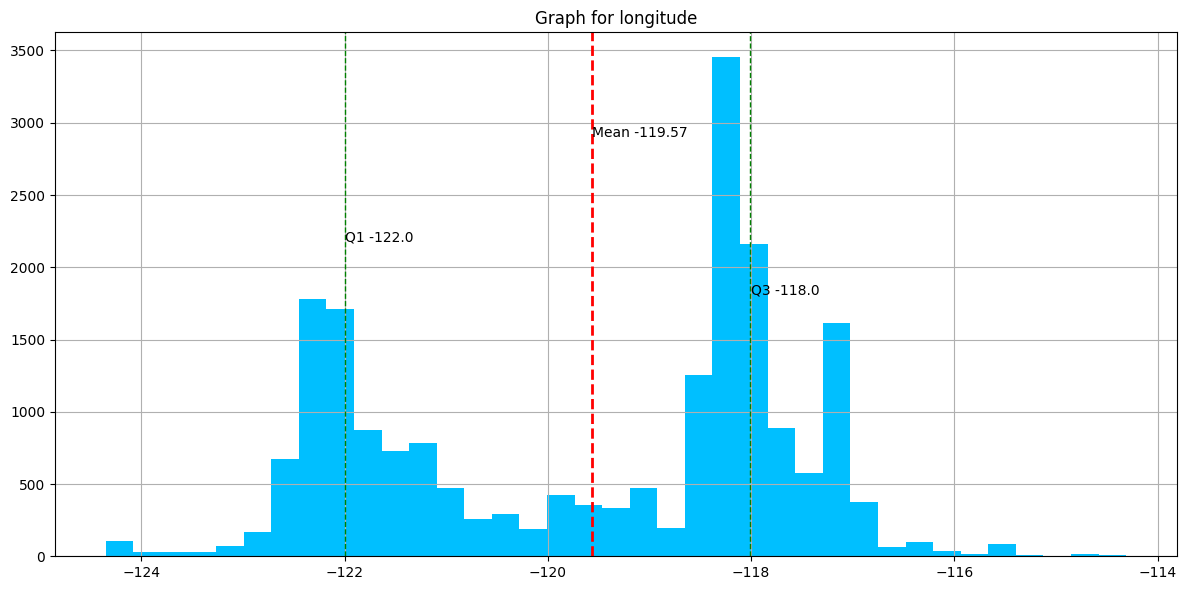

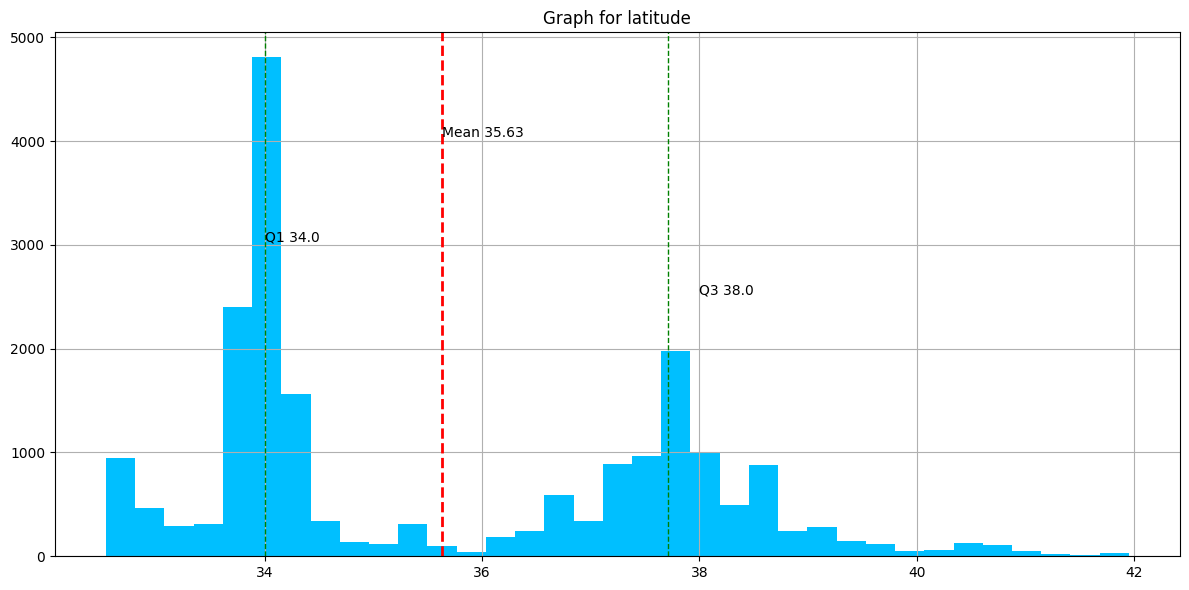

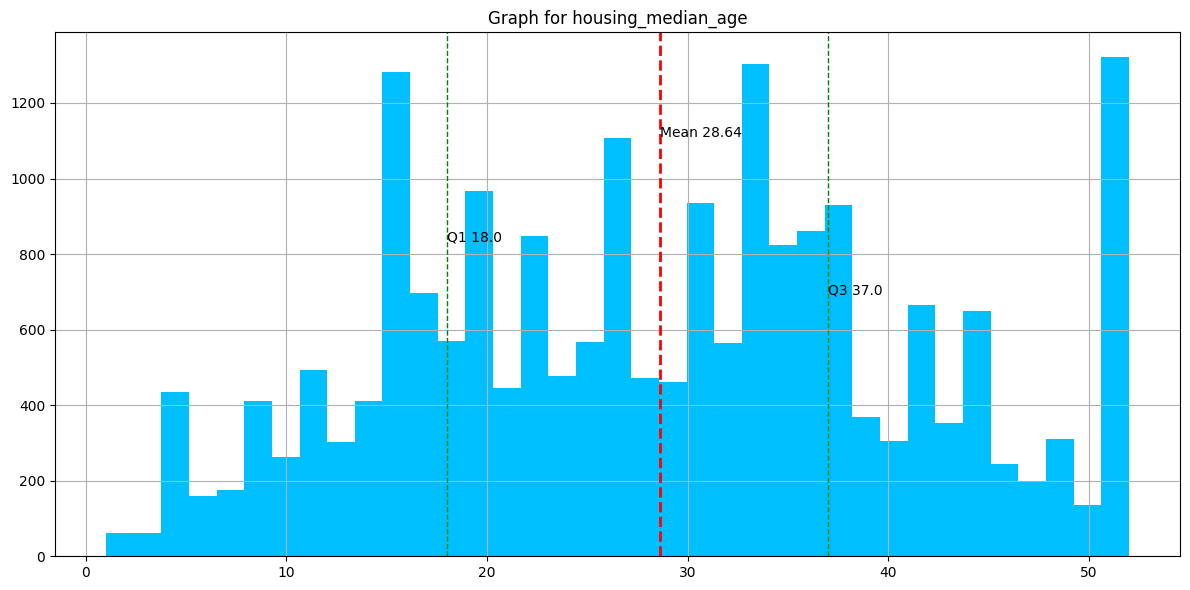

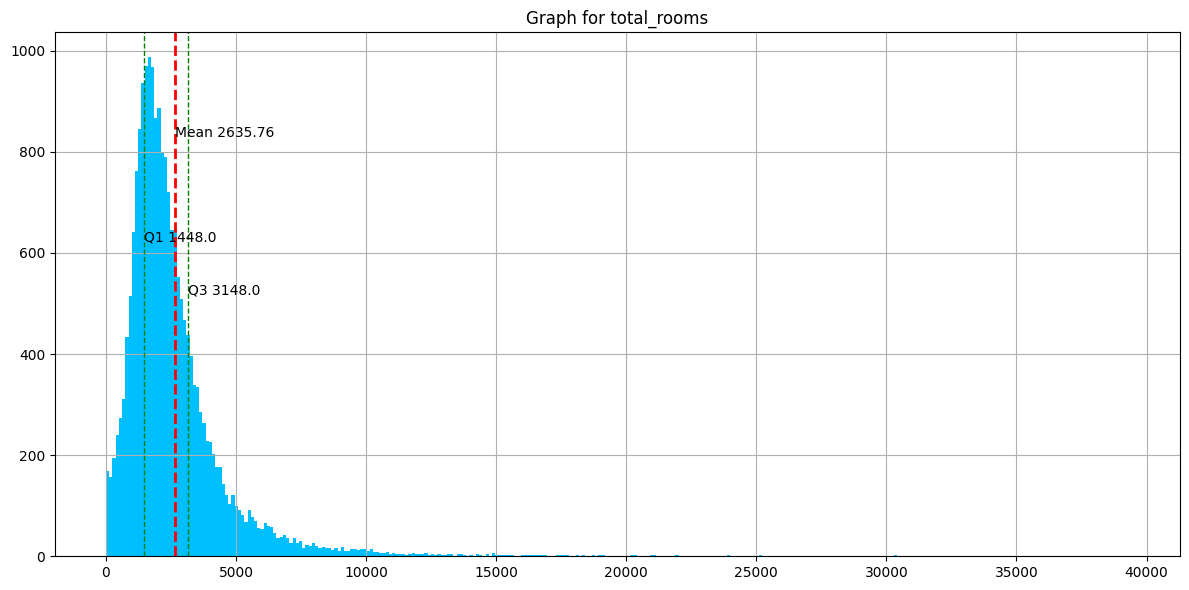

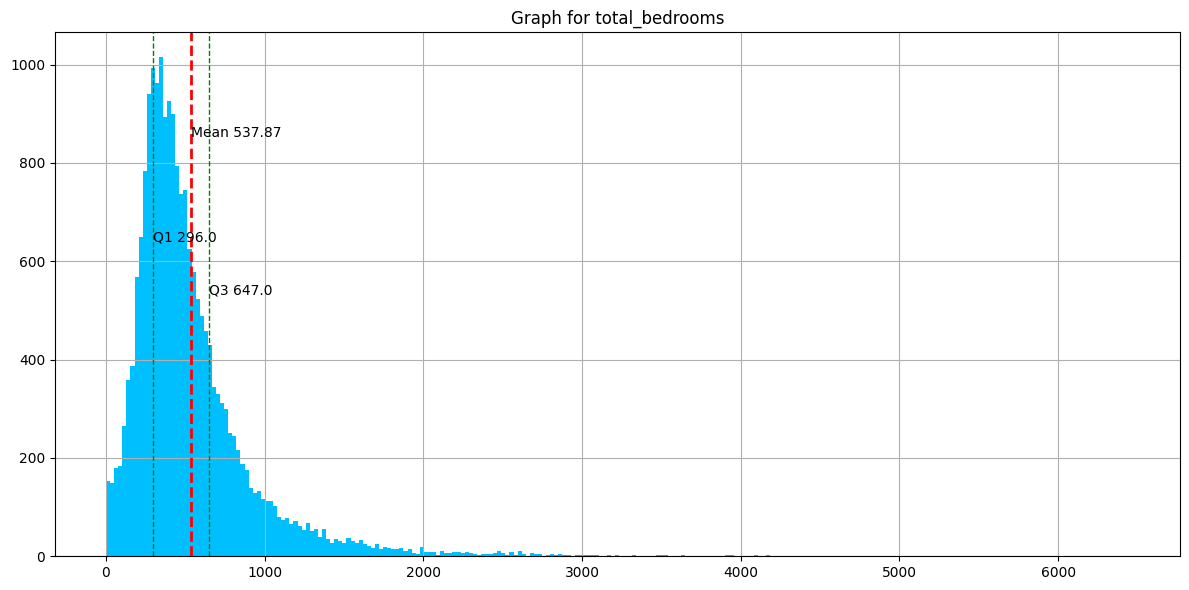

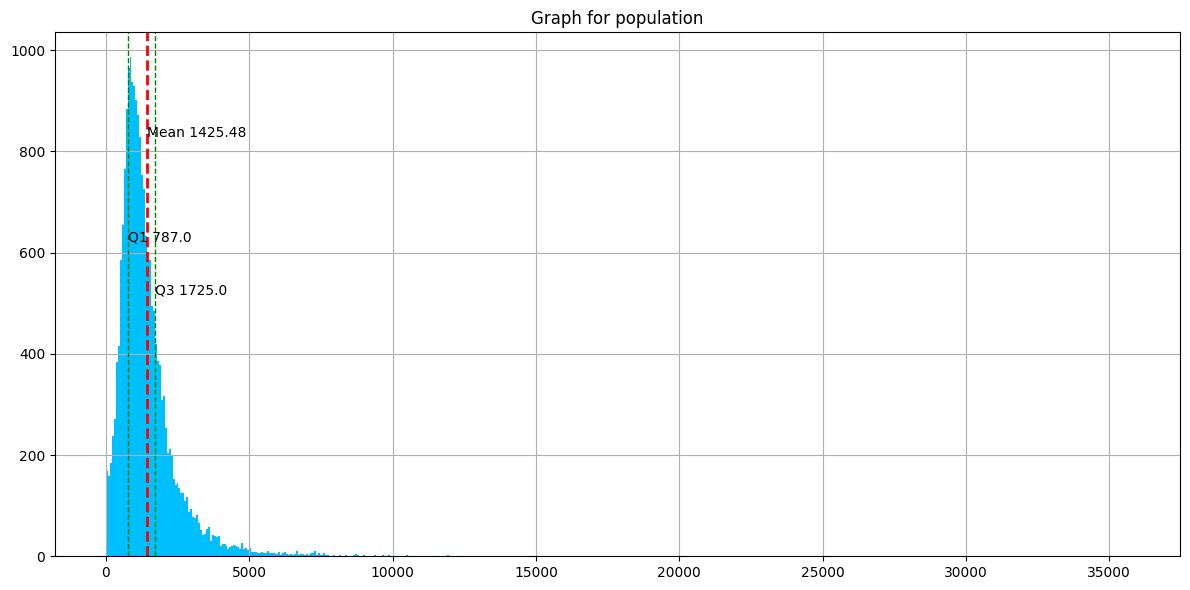

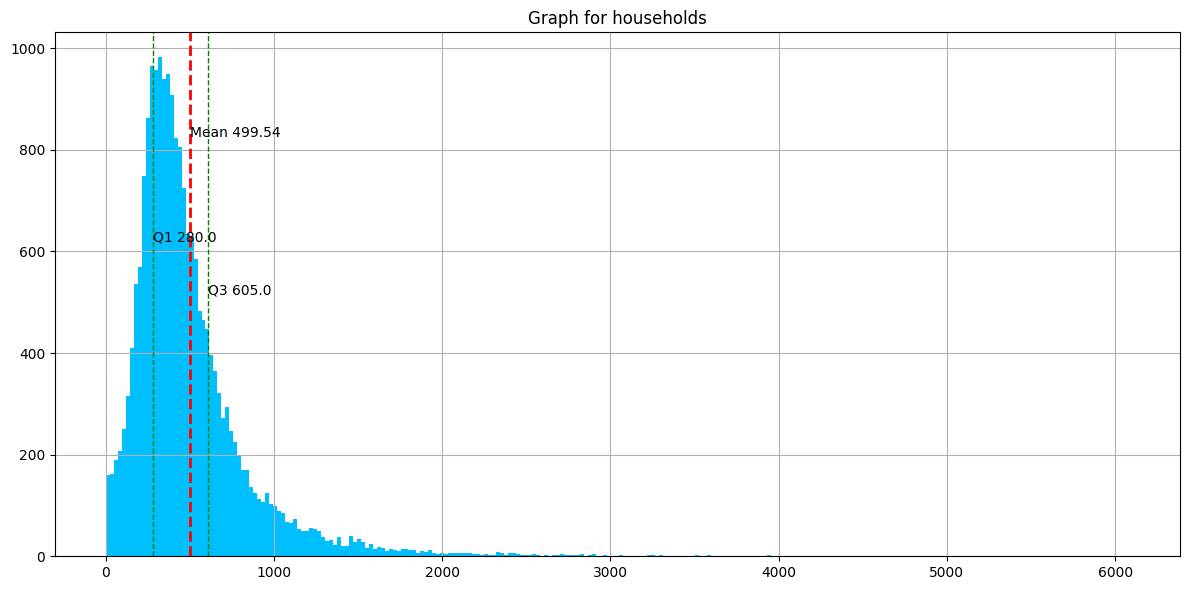

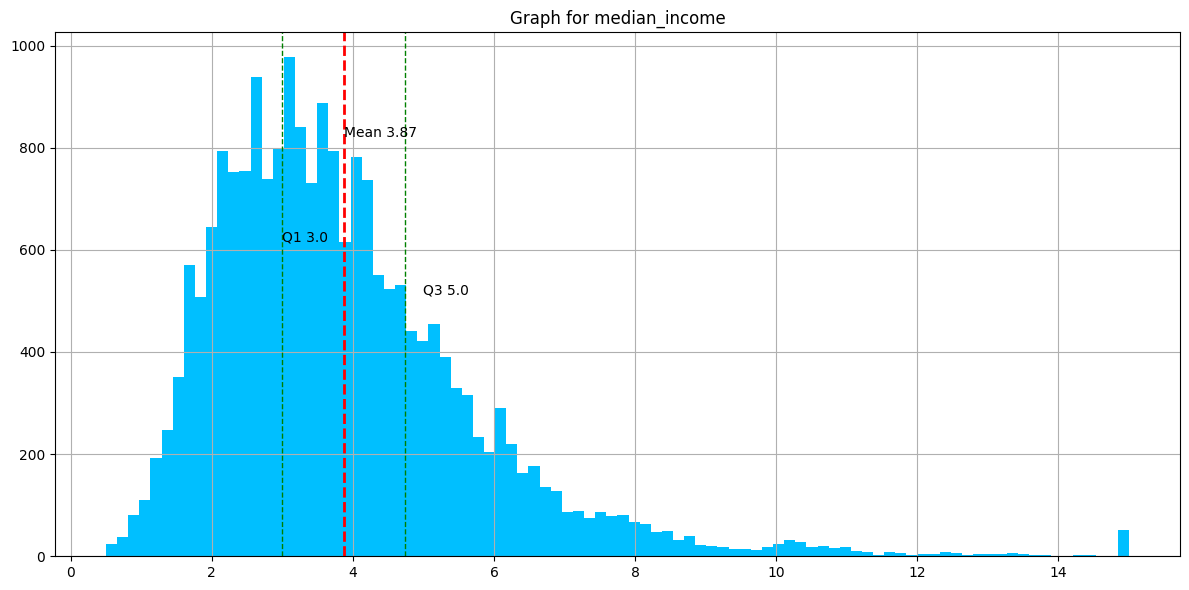

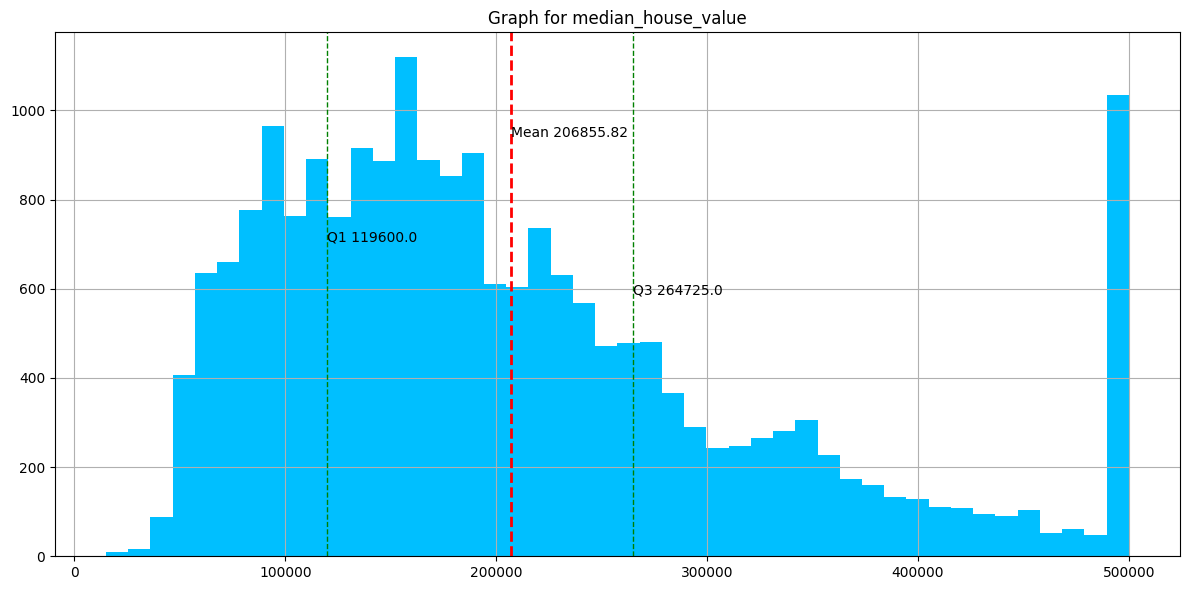

In [24]:
for col in df.columns:
    if df[col].dtype != 'object': 
        Q1 = df[col].quantile(0.25).round()
        Q3 = df[col].quantile(0.75).round()
        Mean = df[col].mean().round(2)
        Mode = df[col].mode()
        plt.figure(figsize=(12,6))
        plt.hist(df[col],bins='auto',color='deepskyblue')

        plt.axvline(Mean, color='r', linestyle='dashed', linewidth=2)
        plt.text(Mean,plt.ylim()[1]*0.8,f'Mean {Mean}')

        plt.axvline(Q1, color='g', linestyle='dashed', linewidth=1)
        plt.text(Q1,plt.ylim()[1]*0.6,f'Q1 {Q1}')

        plt.axvline(df[col].quantile(0.75), color='g', linestyle='dashed', linewidth=1)
        plt.text(Q3,plt.ylim()[1]*0.5,f'Q3 {Q3}')

        plt.title(f'Graph for {col}')
        plt.grid()
        plt.tight_layout()
        plt.show()

- Распределение **медианной стоимости домов** смещено вправо, с длинным "хвостом" в области высоких значений. 50% наблюдений лежать между 119600 и 264725 со средним около 206855$.
- Распределение **дохода** также смещено вправо, однако здесь доминирует группа с низким доходом. Q1 (3.0) и Q3 (5.0) показывают, что доходы в основной группе находятся в диапазоне от 3 до 5 т. $
- Распределение **количества домовладений в жилом массиве** имеет длинный правый хвост. Среднее около 500, 50% наблдюдений в диапазоне 290 и 605 домовладений.
- Распределение **Количества человек, проживающих в жилом массиве** так же сильно скошено вправо. Среднее 1425.48 , 50% выборки находятся в диапазоне от 787 до 1725 человек
- **Количество спален** также имеет распределение с длинным "хвостом". Q1 (296) и Q3 (647) показывают, что основная масса районов имеет количество спален в этом диапазоне.
- **Общее количество комнат** в районе имеет распределение с длинным "хвостом", где большинство значений находятся ближе к нижней границе. Q1 (1448) и Q3 (3148) указывают на диапазон, в котором находится большинство районов.
- **Медианный возраст жилья** имеет почти равномерное распределение, с небольшими пиками. Q1 (18) и Q3 (37) показывают, что большинство районов имеют возраст жилья между этими значениями.
- Распределение **широты** имеет два явных пика.Q1 (34) и Q3 (38) показывают географический диапазон, в котором находится большинство районов.
- Распределение **долготы** также бимодально, с двумя основными кластерами. Q1 (-122) и Q3 (-118) показывают диапазон долготы, в котором находится большинство районов.

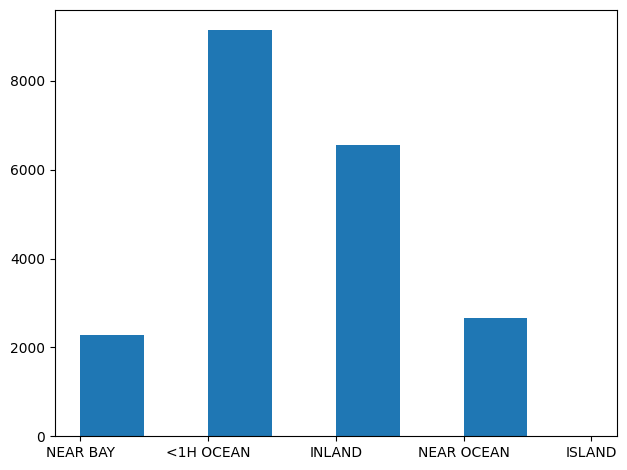

In [25]:
plt.hist(df['ocean_proximity'],bins = 8)
plt.tight_layout()
# Не ругайся, но мне проще так bar отрисовать, auto bin делает 

In [26]:
data.filter(F.col('ocean_proximity') =='ISLAND').count()

5

Для длинного правого смещения можно будет использовать log1p

Чтобы не сильно грузить систему, отобразим на scatter plot дома , взяв long и lait за x  и y

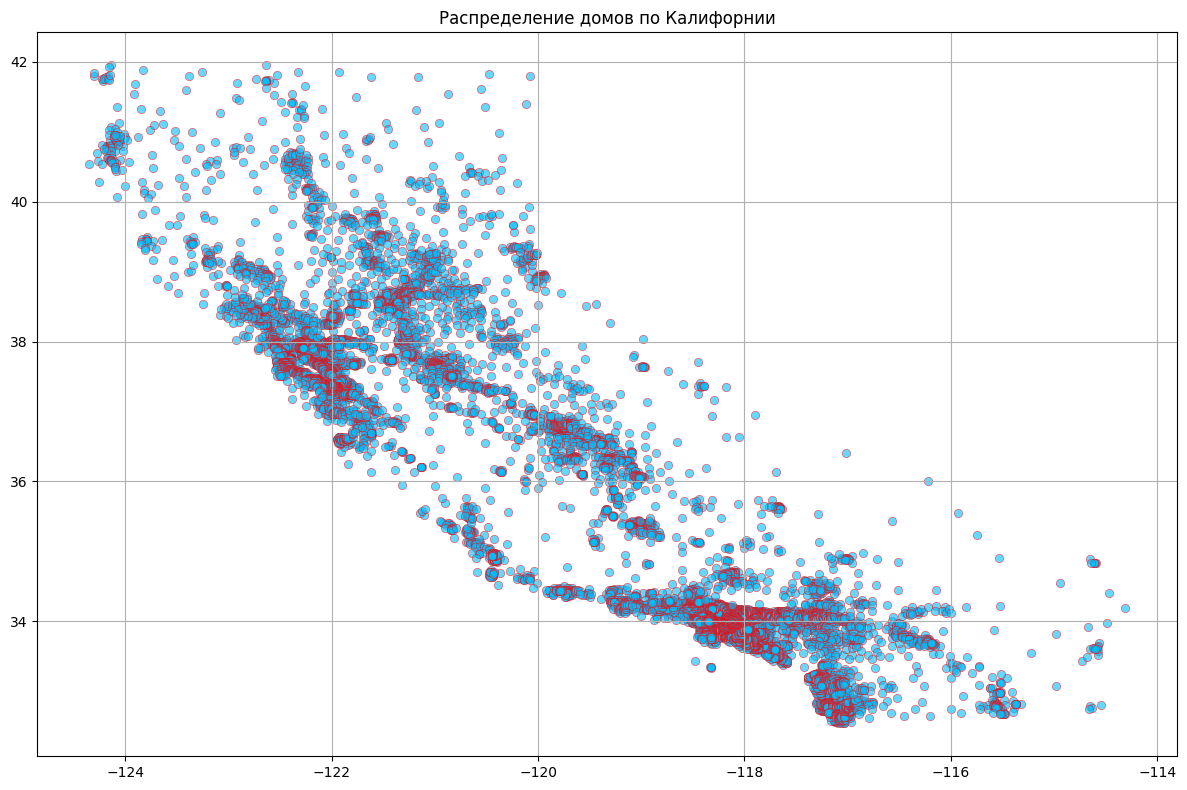

In [27]:
plt.figure(figsize=(12,8))
plt.title('Распределение домов по Калифорнии')
plt.scatter(df['longitude'],df['latitude'],c = 'deepskyblue',edgecolors='red',alpha=0.6,linewidths=0.5)
plt.grid()
plt.tight_layout()

In [28]:
from IPython.display import Image
Image(url='https://cdn.britannica.com/44/4844-050-79224DB3/California.jpg',width=800,height=800)

Плотность заселения, очевидно, выше в особо благоприятных и развитых частях Калифорнии. Все побережье от Северо-Запада до Юго-запада, и часть с границей с Мексикой плотно заселено, Сан Диего, ЛА, Сан Бернардино внизу и Сан Хосе, Сан Франциско верху (курпные известные города). Часть с пустыней на Востоке мало заселена
 

Отдельно посмотрим количество "выбросов", котоыре находятся за +1.5IQR. Но трогать я их не буду, это особенность этих домов, особняки и редкие дорогие дома я убрать не смогу, чтобы не сильно забивать сильно сессию в спарк, обращаться к "выбросам" тоже не буду, просто как факт выведу статистику по количеству

In [29]:
quantiles = {}
for c in data.columns:
    if data.schema[c].dataType in [IntegerType(), FloatType(), DoubleType()]:
        quantiles[c] = data.approxQuantile(c, [0.25, 0.75], 0.01)

In [30]:
for c in quantiles:
    Q1, Q3 = quantiles[c]
    IQR = Q3 - Q1
    
    outliers_above = data.filter(F.col(c) > Q3 + 1.5 * IQR).count()
    outliers_below = data.filter(F.col(c) < Q1 - 1.5 * IQR).count()
    
    print(f"В колонке: {c}, наблюдений ниже 1.5IQR: {outliers_below} ({100*(outliers_below / data.count())} %) , наблюдений выше 1.5IQR: {outliers_above} ({100*(outliers_above / data.count())} %)")

В колонке: longitude, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 0 (0.0 %)
В колонке: latitude, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 0 (0.0 %)
В колонке: housing_median_age, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 0 (0.0 %)
В колонке: total_rooms, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 1358 (6.579457364341085 %)
В колонке: population, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 1270 (6.153100775193798 %)
В колонке: households, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 1288 (6.24031007751938 %)
В колонке: median_income, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 735 (3.561046511627907 %)
В колонке: median_house_value, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 1114 (5.397286821705427 %)
В колонке: total_bedrooms, наблюдений ниже 1.5IQR: 0 (0.0 %) , наблюдений выше 1.5IQR: 1363 (6.603682170542635 %)


Чекнем NULL

In [31]:
data.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+
|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+
|        0|       0|                 0|          0|         0|         0|            0|                 0|              0|             0|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------+



In [32]:
def draw_corr(df):
    num_col = set()
    for col in df.columns:
        if df[col].dtype in [int,float]:
            num_col.add(col)
    matr = df[list(num_col)].corr(method='spearman')
    mask = np.triu(np.ones_like(matr, dtype=bool))  # Маска для верхнего треугольника
    plt.figure(figsize=(10, 8))
    sns.heatmap(matr, annot=True, cmap = 'coolwarm', fmt='.2f', vmin=-1, vmax=1,mask = mask)
    plt.show()

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


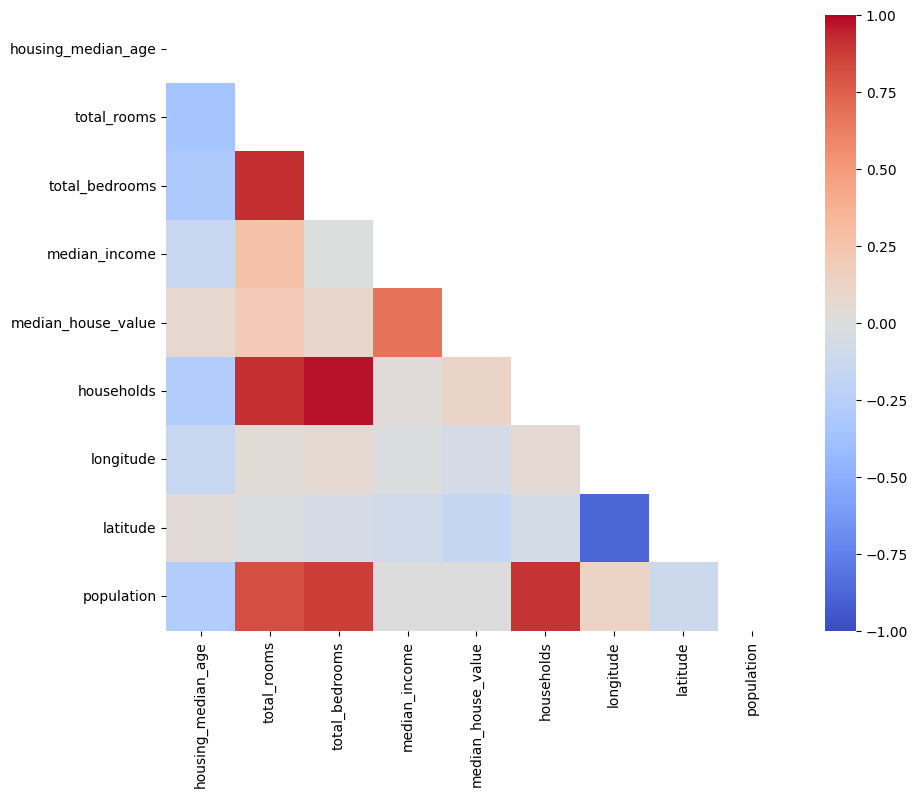

In [33]:
draw_corr(df)

Стоимость дома имеет среднюю корреляцию в доходом, 

слабую корреляцию с возрастом, комнатами, спальнями, householders 

высокая корреляция между total_rooms, total_bedrooms, population, и households, они измеряют объем населения и жилого фонда, поэтому их высокая корреляция логична

0 Корреляции с популяцией 

Сильная обратная корреляция между longitude и latitude

In [34]:
def del_multi(df):
     df['pop_hh_rat'] = df['population'] /  df['households']
     df['tr_tbr_rat'] = df['total_rooms'] /  df['total_bedrooms']
     df = df.drop(columns=['households','population','total_bedrooms','total_rooms'])
     return df

In [35]:
df = del_multi(df)

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


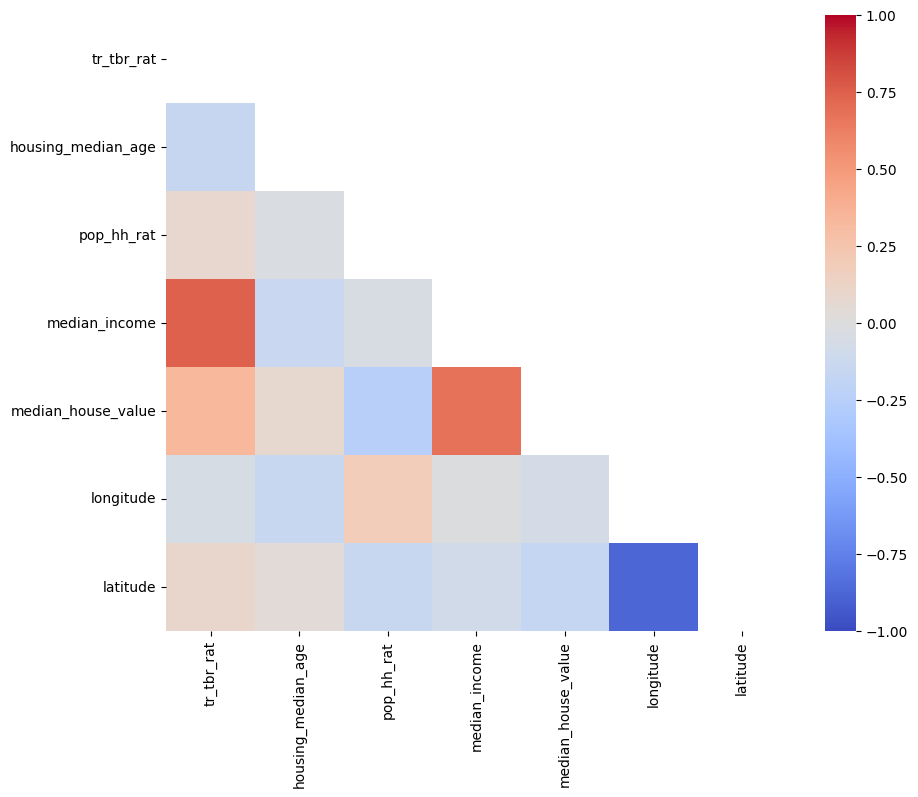

In [36]:
draw_corr(df)

Убрали мультиколлинеррность, но осталась отрицательная между long lat (оставим). Можно еще добавит ьстепенные признаки(poly)

In [37]:
def del_multi_sp(df):
    df = df.withColumn('hh_pop_rat', F.when(F.col('population') != 0, F.col('households') / F.col('population')).otherwise(None)) \
           .withColumn('tr_tbr_rat', F.when(F.col('total_rooms') != 0, F.col('total_bedrooms') / F.col('total_rooms')).otherwise(None))
    df = df.drop('households', 'population', 'total_bedrooms', 'total_rooms')
    return df

In [38]:
data = del_multi_sp(data)

In [39]:
def scatter_plot(df):
    num_col = set()
    for col in df.columns:
        if df[col].dtype in [int,float] and col!='median_house_value':
            num_col.add(col)
    for elem in list(num_col):        
        plt.figure(figsize=(12,8))
        plt.title(f'График взаимодействия для {elem}')
        plt.ylabel(f'{elem}')
        plt.xlabel(f'median_house_value')
        plt.scatter(df['median_house_value'],df[elem])
        plt.show()

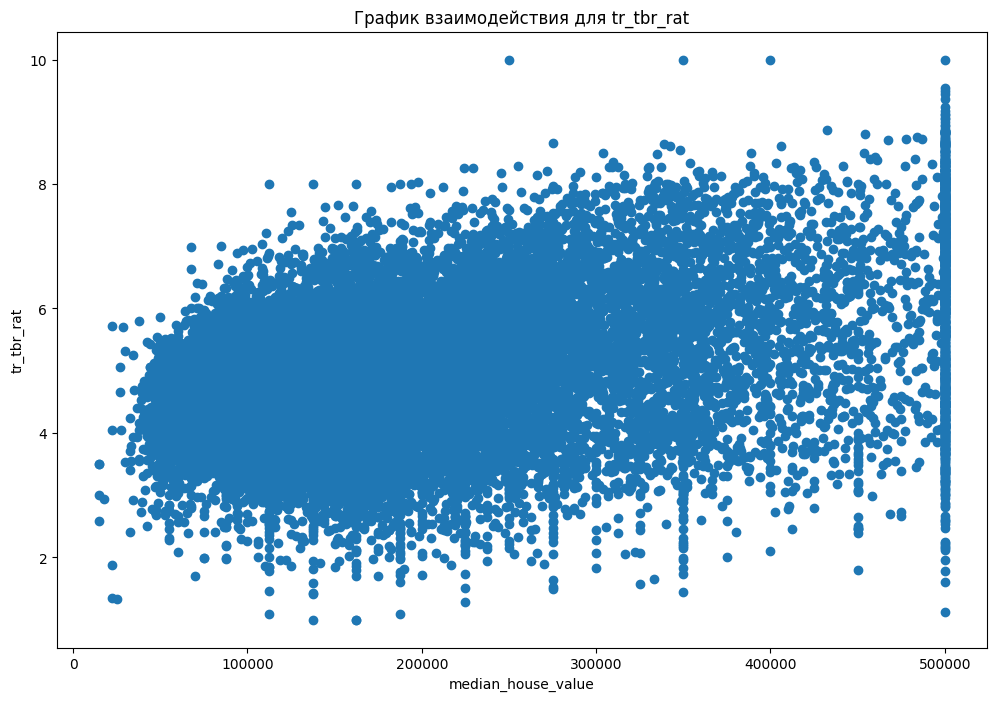

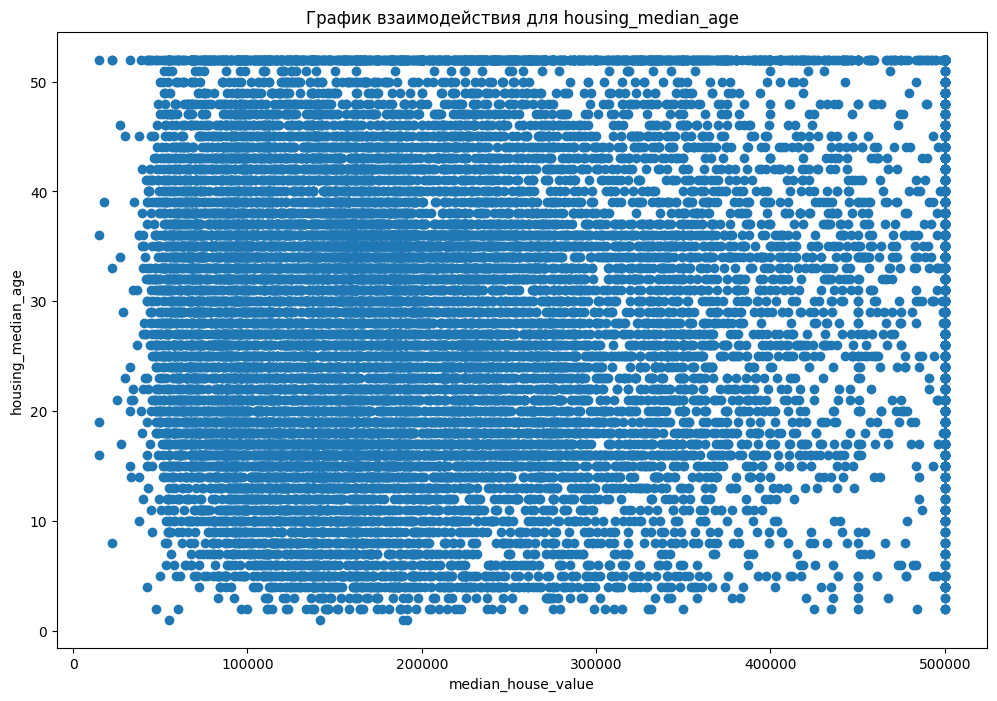

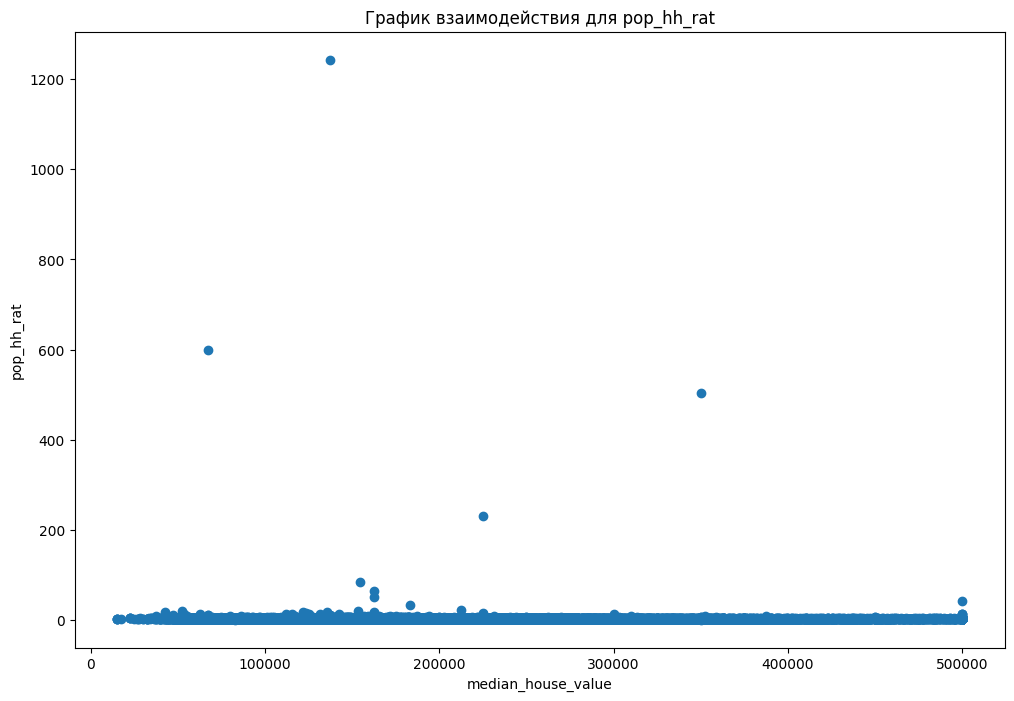

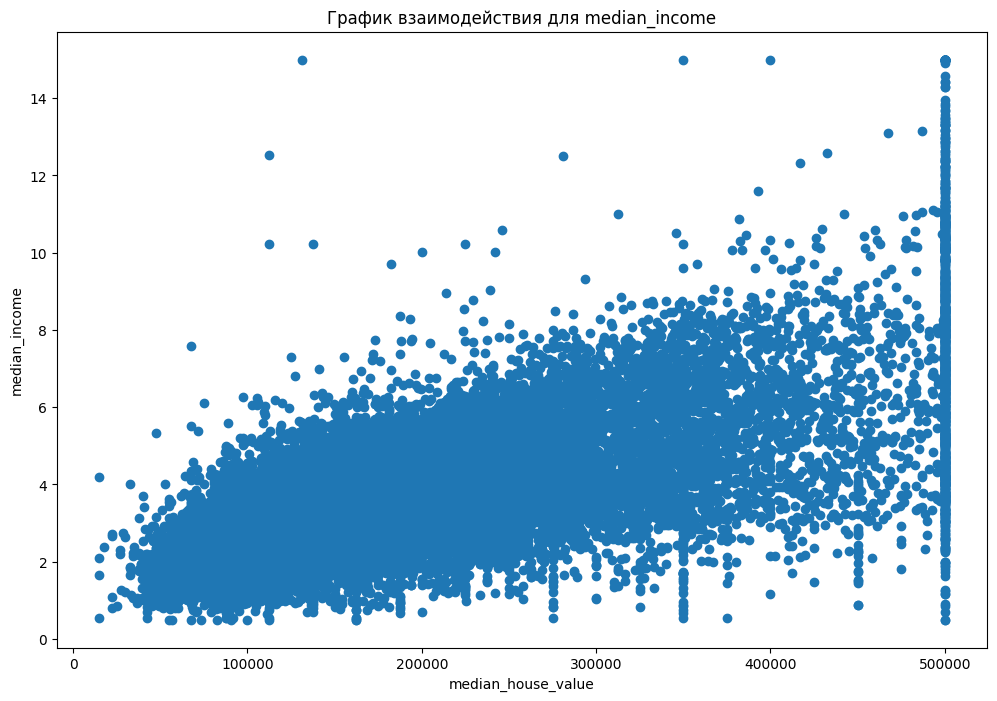

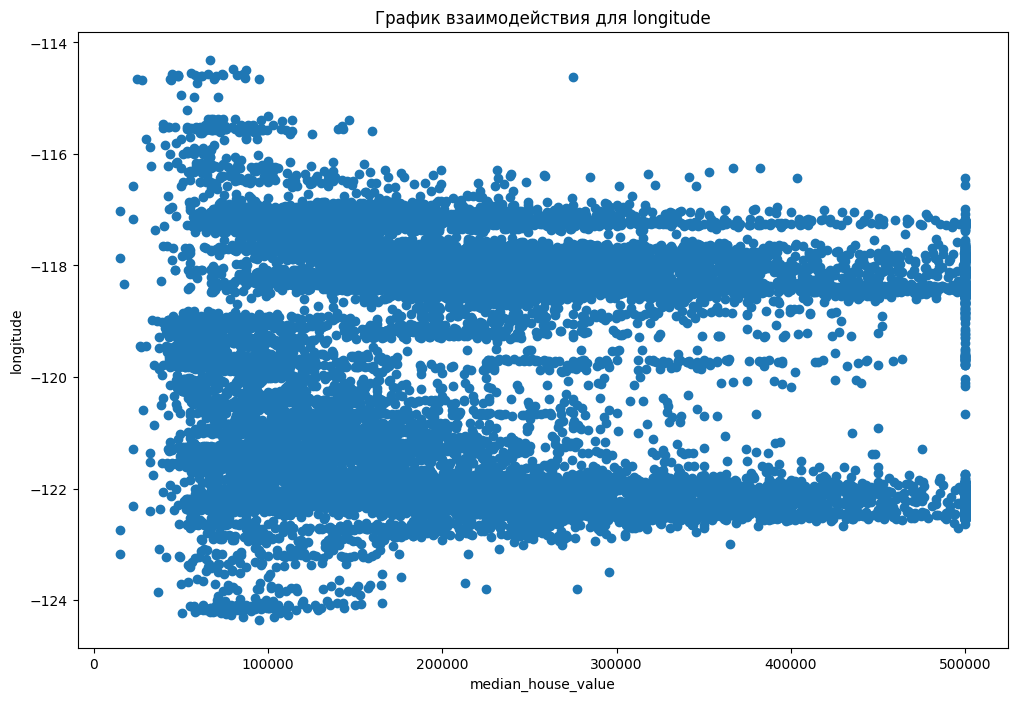

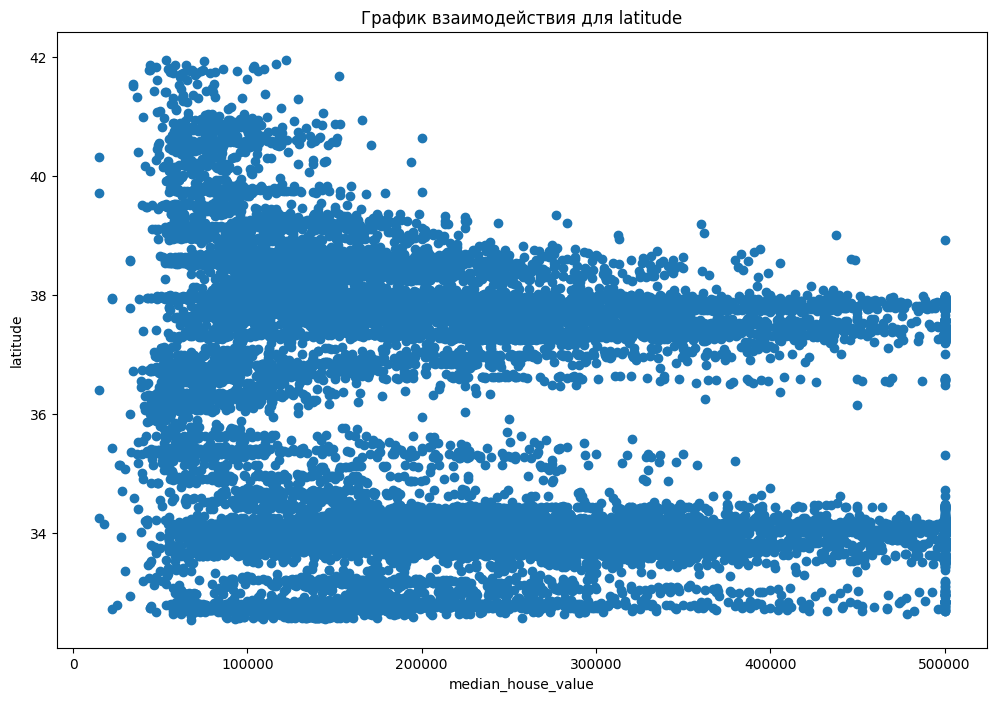

In [40]:
scatter_plot(df)

- Медианный возраст жилья может быть важным фактором, но его влияние на стоимость жилья, возможно, нелинейное. Есть вероятное насыщение на уровне 50 лет, что может указывать на ограничения в данных (например, старые дома могут быть переоценены).
- Географическое положение *latitude* явно связано с median_house_value.
- *tr_tbr_rat* соотношение может не оказывать значительного влияния на стоимость жилья само по себе, но может быть полезным как часть более сложного признака или взаимодействия признаков.
- *hh_pop_rat* может не быть сильным предиктором стоимости жилья, но может указывать на районы с уникальной демографией, которые требуют дальнейшего анализа.
- Географическая долгота *longitude* явно оказывает влияние на стоимость жилья.
- *median_income* является сильным предиктором стоимости жилья и может быть одним из ключевых факторов в модели.

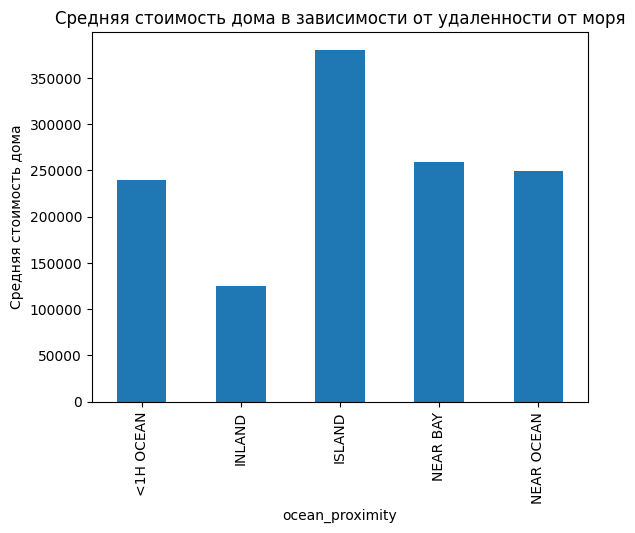

In [41]:
df.groupby('ocean_proximity')['median_house_value'].mean().plot(kind='bar')
plt.title('Средняя стоимость дома в зависимости от удаленности от моря')
plt.ylabel('Средняя стоимость дома')
plt.show()

In [42]:
# "Та же морда в профиль"

data.groupBy('ocean_proximity') \
.agg(F.mean('median_house_value').alias('avg_house_value')).orderBy('avg_house_value').show()

+---------------+------------------+
|ocean_proximity|   avg_house_value|
+---------------+------------------+
|         INLAND|124805.39200122119|
|      <1H OCEAN|240084.28546409807|
|     NEAR OCEAN|249433.97742663656|
|       NEAR BAY|259212.31179039303|
|         ISLAND|          380440.0|
+---------------+------------------+



Самый дорогие дома на острове, самые дешевые без доступа к морю. Примерно одинаково стоят дома около Океана и < 1 часа до океана, чуть выше этих двух категорий расположились дома у залива. Я считаю, что этот критерий может быть важен. как минимум, по этому графику. И при добавлении его в пайплайн я буду юзать stringindexer, а не ohe, так как тут категории имеют ранг "престижа", если это так можно назвать. Ближе к океану - дороже, круче, все, как в жизни, в общем.


In [43]:
# data = del_multi_sp(data)

In [44]:
# Хз. где аннотации)

In [45]:
def ocean(df):
    # Создаем столбец с ручным кодированием
    df = df.withColumn('ocean_proximity_custom',
    F.when(df['ocean_proximity'] == 'INLAND', 0)
    .when(df['ocean_proximity'] == '<1H OCEAN', 1)
    .when(df['ocean_proximity'] == 'NEAR OCEAN', 2)
    .when(df['ocean_proximity'] == 'NEAR BAY', 3)
    .when(df['ocean_proximity'] == 'ISLAND', 4)
    .otherwise(0))
    return df

Pipeline предобработки:

In [46]:
# для пайплайна
# ocean_udf = udf(ocean, IntegerType())
# class UDFTransformer(Transformer):
#     def __init__(self, inputCol=None, outputCol=None, udf=None):
#         super(UDFTransformer, self).__init__()
#         self.inputCol = inputCol
#         self.outputCol = outputCol
#         self.udf = udf

#     def _transform(self, df: DataFrame) -> DataFrame:
#         return df.withColumn(self.outputCol, self.udf(df[self.inputCol]))

In [47]:
# data_with_ocean = ocean(data)

In [48]:
def find_columns_with_nulls_or_nans(dafr):
    columns_with_missing_values = []
    
    for column in dafr.columns:
        # Проверяем наличие null или NaN значений в столбце
        null_count = dafr.filter(F.col(column).isNull() | F.isnan(F.col(column))).count()
        
        if null_count > 0:
            columns_with_missing_values.append(column)
    
    return columns_with_missing_values

# columns_with_nulls_or_nans = find_columns_with_nulls_or_nans(data_with_ocean)

In [49]:
# # тАК КАК null бЫли и я их заполнил в самом начале, этот этап не выполнится
# data_imputed = data_with_ocean
# if len(columns_with_nulls_or_nans)!=0:
#     imputer = Imputer(inputCols=columns_with_nulls_or_nans, outputCols=[col + "_filled" for col in columns_with_nulls_or_nans])
#     data_imputed = imputer.fit(data_with_ocean).transform(data_with_ocean)

In [50]:
# num_col = [name for name, dtype in data_imputed.dtypes if (dtype in ('int', 'double','float')) and (name!='median_house_value')]

In [51]:
# input_columns = num_col + ['ocean_proximity_custom']

# # Создаем вектор из признаков
# vector_assembler = VectorAssembler(inputCols=input_columns, outputCol="assembled_features")
# data_with_features = vector_assembler.transform(data_imputed)

# # Масштабируем признаки
# scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")
# scaled_data = scaler.fit(data_with_features).transform(data_with_features)

# # Выбор финальных столбцов для обучения
# final_data = scaled_data.select("scaled_features", "median_house_value")

In [52]:
# train_data, test_data = final_data.randomSplit([.8,.2], seed=42)

In [53]:
# # Модель линейной регрессии
# lr = LinearRegression(featuresCol="scaled_features", labelCol="median_house_value")

# # GridSearch для подбора гиперпараметров
# paramGrid = ParamGridBuilder() \
#     .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
#     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .build()

# # Кросс-валидация
# crossval = CrossValidator(estimator=lr,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=RegressionEvaluator(labelCol="median_house_value"),
#                           numFolds=3)

# # Обучение модели
# cv_model = crossval.fit(train_data)

In [54]:
# predictions = cv_model.transform(test_data)

In [55]:
# # RMSE (Root Mean Squared Error)
# rmse_evaluator = RegressionEvaluator(
#     labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
# rmse = rmse_evaluator.evaluate(predictions)

# # MAE (Mean Absolute Error)
# mae_evaluator = RegressionEvaluator(
#     labelCol="median_house_value", predictionCol="prediction", metricName="mae")
# mae = mae_evaluator.evaluate(predictions)

# # R² (R-squared)
# r2_evaluator = RegressionEvaluator(
#     labelCol="median_house_value", predictionCol="prediction", metricName="r2")
# r2 = r2_evaluator.evaluate(predictions)

# # 3. Вывод результатов
# print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"R-squared (R2): {r2}")

In [56]:
class OceanProximityEncoder(Transformer):
    def _transform(self, df: DataFrame) -> DataFrame:
        return ocean(df)

In [57]:

# Шаг 1: Кодирование ocean_proximity
ocean_encoder = OceanProximityEncoder()

# Шаг 2: Импутация пропусков
columns_with_nulls_or_nans = find_columns_with_nulls_or_nans(data)
if columns_with_nulls_or_nans:
    imputer = Imputer(inputCols=columns_with_nulls_or_nans,
                      outputCols=[col + "_filled" for col in columns_with_nulls_or_nans])
else:
    imputer = None  # если пропусков нет, пропускаем этот шаг

# Шаг 3: Объединение числовых признаков и закодированного признака в один вектор
num_col = [name for name, dtype in data.dtypes if (dtype in ('int', 'double', 'float')) and (name != 'median_house_value')]
input_columns = num_col + ['ocean_proximity_custom']
vector_assembler = VectorAssembler(inputCols=input_columns, outputCol="assembled_features")

# Шаг 4: Масштабирование признаков
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

In [58]:
# Шаг 5: Модель линейной регрессии
lr = LinearRegression(featuresCol="scaled_features", labelCol="median_house_value")

# Шаг 6: GridSearch для подбора гиперпараметров

reg_param_range = [0.01 * i for i in range(1, 11)]  # Пример: 0.01, 0.02, ..., 0.10
elastic_net_range = [0.0, 0.5, 1.0]
max_iter_range = [50, 100, 150]

# Создание сетки гиперпараметров
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, reg_param_range) \
    .addGrid(lr.elasticNetParam, elastic_net_range) \
    .addGrid(lr.maxIter, max_iter_range) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="median_house_value"),
                          numFolds=5)

# 7. Сборка пайплайна
stages = [ocean_encoder]

if imputer:
    stages.append(imputer)

stages.extend([vector_assembler, scaler, crossval])

pipeline = Pipeline(stages=stages)

In [59]:
# 4. Применение пайплайна к данным
pipeline_model = pipeline.fit(data)
predictions = pipeline_model.transform(data)

In [60]:
# Оценка метрик
rmse_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="r2")

rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 66652.46734410101
Mean Absolute Error (MAE): 48495.29000927434
R-squared (R2): 0.6663624796762442


С Ohe, вместо кастомного stringindexer

In [61]:
# Шаг 1: Кодирование ocean_proximity
ocean_encoder_ohe = OceanProximityEncoder()

# Шаг 2: Импутация пропусков
columns_with_nulls_or_nans_ohe = find_columns_with_nulls_or_nans(data)
if columns_with_nulls_or_nans_ohe:
    imputer_ohe = Imputer(inputCols=columns_with_nulls_or_nans_ohe,
                          outputCols=[col + "_filled" for col in columns_with_nulls_or_nans_ohe])
else:
    imputer_ohe = None  # если пропусков нет, пропускаем этот шаг

# Шаг 3: Применение OneHotEncoder к столбцу 'ocean_proximity_custom'
ohe_encoder = OneHotEncoder(inputCol="ocean_proximity_custom", outputCol="ocean_proximity_ohe")

# Шаг 4: Найдём числовые столбцы
num_col_ohe = [name for name, dtype in data.dtypes 
               if (dtype in ('int', 'double', 'float')) and (name != 'median_house_value')]

# Шаг 5: Добавляем OHE-признак к числовым признакам
input_columns_ohe = num_col_ohe + ['ocean_proximity_ohe']

# Шаг 6: Ассемблер для объединения признаков в один вектор
assembler_ohe = VectorAssembler(inputCols=input_columns_ohe, outputCol="features_ohe")

# Шаг 7: Стандартизация признаков
scaler_ohe = StandardScaler(inputCol="features_ohe", outputCol="scaled_features_ohe")

In [62]:
# Шаг 8: Линейная регрессия
lr_ohe = LinearRegression(featuresCol="scaled_features_ohe", labelCol="median_house_value")

# GridSearch для подбора гиперпараметров
paramGrid_ohe = ParamGridBuilder() \
    .addGrid(lr_ohe.regParam, reg_param_range) \
    .addGrid(lr_ohe.elasticNetParam, elastic_net_range) \
    .addGrid(lr_ohe.maxIter, max_iter_range) \
    .build()

In [63]:

# Кросс-валидация
crossval_ohe = CrossValidator(estimator=lr_ohe,
                              estimatorParamMaps=paramGrid_ohe,
                              evaluator=RegressionEvaluator(labelCol="median_house_value"),
                              numFolds=5)

# Собираем весь пайплайн
stages_ohe = [ocean_encoder_ohe]

if imputer_ohe:
    stages_ohe.append(imputer_ohe)

stages_ohe.extend([ohe_encoder, assembler_ohe, scaler_ohe, crossval_ohe])

pipeline_ohe = Pipeline(stages=stages_ohe)

In [64]:
# Обучение модели с помощью пайплайна
cv_model_ohe = pipeline_ohe.fit(data)

In [65]:
predictions_ohe = cv_model_ohe.transform(data)

In [66]:
# Вывод метрик
evaluator_ohe = RegressionEvaluator(labelCol="median_house_value")

rmse_ohe = evaluator_ohe.evaluate(predictions_ohe, {evaluator_ohe.metricName: "rmse"})
mae_ohe = evaluator_ohe.evaluate(predictions_ohe, {evaluator_ohe.metricName: "mae"})
r2_ohe = evaluator_ohe.evaluate(predictions_ohe, {evaluator_ohe.metricName: "r2"})

print(f"RMSE (OHE): {rmse_ohe}")
print(f"MAE (OHE): {mae_ohe}")
print(f"R2 (OHE): {r2_ohe}")

RMSE (OHE): 66000.33319112178
MAE (OHE): 47814.54479610826
R2 (OHE): 0.6728592242387323


Без категориального столбца

In [67]:
data_no_category = data.drop('ocean_proximity')

In [68]:
# Создание списка числовых столбцов без категориального
num_col = [name for name, dtype in data_no_category.dtypes if (dtype in ('int', 'double')) and (name != 'median_house_value')]
# Шаг 2: Импутация пропусков
columns_with_nulls_or_nans_2 = find_columns_with_nulls_or_nans(data)
if columns_with_nulls_or_nans_2:
    imputer_2 = Imputer(inputCols=columns_with_nulls_or_nans_2,
                      outputCols=[col + "_filled" for col in columns_with_nulls_or_nans_2])
else:
    imputer_2 = None  # если пропусков нет, пропускаем этот шаг
# VectorAssembler для числовых признаков
assembler_2 = VectorAssembler(inputCols=num_col, outputCol="features")

# StandardScaler для стандартизации признаков
scaler_2 = StandardScaler(inputCol="features", outputCol="scaled_features")

# Линейная регрессия
lr_2 = LinearRegression(featuresCol="scaled_features", labelCol="median_house_value")

# GridSearch для подбора гиперпараметров
paramGrid_2 = ParamGridBuilder() \
    .addGrid(lr_2.regParam, reg_param_range) \
    .addGrid(lr_2.elasticNetParam, elastic_net_range) \
    .addGrid(lr_2.maxIter, max_iter_range) \
    .build()
# Кросс-валидация
crossval_2 = CrossValidator(estimator=lr_2,
                              estimatorParamMaps=paramGrid_2,
                              evaluator=RegressionEvaluator(labelCol="median_house_value"),
                              numFolds=5)

# 7. Сборка пайплайна
stages_2 = []
if imputer_2:
    stages_2.append(imputer_2)

stages_2.extend([assembler_2, scaler_2, crossval_2])
pipeline_2 = Pipeline(stages=stages_2)

In [69]:
# Обучение модели
pipeline_model_2 = pipeline_2.fit(data)

# Предсказания
predictions_2 = pipeline_model_2.transform(data)

In [73]:
# Оценка метрик
rmse_evaluator_2 = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
mae_evaluator_2 = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="mae")
r2_evaluator_2 = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="r2")

rmse_2 = rmse_evaluator_2.evaluate(predictions_2)
mae_2 = mae_evaluator_2.evaluate(predictions_2)
r2_2 = r2_evaluator_2.evaluate(predictions_2)

print(f"RMSE: {rmse_2}")
print(f"MAE: {mae_2}")
print(f"R2^2: {r2_2}")

RMSE: 66778.05811401256
MAE: 48636.26895203484
R2^2: 0.6651039735258601


In [71]:
def compare_models_metrics(rmse, mae, r2, rmse_ohe, mae_ohe, r2_ohe, rmse_no_proc, mae_no_proc, r2_no_proc):
    comparison_results = {}

    # Сравнение RMSE
    if rmse < rmse_ohe and rmse < rmse_no_proc:
        comparison_results['RMSE'] = f"Модель 1 имеет меньшее RMSE ({rmse:.4f}) чем Модель OHE ({rmse_ohe:.4f}) и Модель без категориального столбца ({rmse_no_proc:.4f})"
    elif rmse_ohe < rmse and rmse_ohe < rmse_no_proc:
        comparison_results['RMSE'] = f"Модель OHE имеет меньшее RMSE ({rmse_ohe:.4f}) чем Модель 1 ({rmse:.4f}) и Модель без категориального столбца ({rmse_no_proc:.4f})"
    elif rmse_no_proc < rmse and rmse_no_proc < rmse_ohe:
        comparison_results['RMSE'] = f"Модель без категориального столбца имеет меньшее RMSE ({rmse_no_proc:.4f}) чем Модель 1 ({rmse:.4f}) и Модель OHE ({rmse_ohe:.4f})"
    else:
        comparison_results['RMSE'] = f"Одинаковая RMSE среди всех моделей"

    # Сравнение MAE
    if mae < mae_ohe and mae < mae_no_proc:
        comparison_results['MAE'] = f"Модель 1 имеет меньшее MAE ({mae:.4f}) чем Модель OHE ({mae_ohe:.4f}) и Модель без категориального столбца ({mae_no_proc:.4f})"
    elif mae_ohe < mae and mae_ohe < mae_no_proc:
        comparison_results['MAE'] = f"Модель OHE имеет меньшее MAE ({mae_ohe:.4f}) чем Модель 1 ({mae:.4f}) и Модель без категориального столбца ({mae_no_proc:.4f})"
    elif mae_no_proc < mae and mae_no_proc < mae_ohe:
        comparison_results['MAE'] = f"Модель без категориального столбца имеет меньшее MAE ({mae_no_proc:.4f}) чем Модель 1 ({mae:.4f}) и Модель OHE ({mae_ohe:.4f})"
    else:
        comparison_results['MAE'] = f"Одинаковая MAE среди всех моделей"

    # Сравнение R²
    if r2 > r2_ohe and r2 > r2_no_proc:
        comparison_results['R2'] = f"Модель 1 имеет выше R² ({r2:.4f}) чем Модель OHE ({r2_ohe:.4f}) и Модель без категориального столбца ({r2_no_proc:.4f})"
    elif r2_ohe > r2 and r2_ohe > r2_no_proc:
        comparison_results['R2'] = f"Модель OHE имеет выше R² ({r2_ohe:.4f}) чем Модель 1 ({r2:.4f}) и Модель без категориального столбца ({r2_no_proc:.4f})"
    elif r2_no_proc > r2 and r2_no_proc > r2_ohe:
        comparison_results['R2'] = f"Модель без категориального столбца имеет выше R² ({r2_no_proc:.4f}) чем Модель 1 ({r2:.4f}) и Модель OHE ({r2_ohe:.4f})"
    else:
        comparison_results['R2'] = f"Одинаковый R² среди всех моделей"

    # Вывод результатов сравнения
    for metric, result in comparison_results.items():
        print(f"{result}")

In [72]:
compare_models_metrics(rmse, mae, r2, rmse_ohe, mae_ohe, r2_ohe, rmse_2, mae_2, r2_2)

Модель OHE имеет меньшее RMSE (66000.3332) чем Модель 1 (66652.4673) и Модель без категориального столбца (66778.0581)
Модель OHE имеет меньшее MAE (47814.5448) чем Модель 1 (48495.2900) и Модель без категориального столбца (48636.2690)
Модель OHE имеет выше R² (0.6729) чем Модель 1 (0.6664) и Модель без категориального столбца (0.6651)


В ходе работы был проведен первичный анализ, визуализация признаков, составлен "портрет" всех представленных экземпляров датафрейма

В ходе выполнения работы было создано и оценено три различные модели линейной регрессии для прогнозирования стоимости жилья:

- Модель с ручным кодированием категориального признака ocean_proximity.
- Модель с использованием OneHotEncoding для кодирования категориального признака ocean_proximity.
- Модель, в которой категориальный признак ocean_proximity был полностью исключен из анализа.
Результаты сравнения моделей:

- Модель OHE имеет меньшее RMSE (66,000.33) по сравнению с Моделью 1 (66,652.47) и Моделью без категориального столбца (66,778.06).
- Модель OHE имеет меньшее MAE (47,814.54) по сравнению с Моделью 1 (48,495.29) и Моделью без категориального столбца (48,636.27).
- Модель OHE имеет выше R² (0.6729) по сравнению с Моделью 1 (0.6664) и Моделью без категориального столбца (0.6651).

Из проделанной работы можно сделать следующие выводы:

Кодирование категориальных признаков влияет на качество модели. Исключение категориального признака из анализа привело к ухудшению качества прогноза, что видно по более высоким значениям RMSE и MAE, а также по более низкому значению R².

Модель с OneHotEncoding (OHE) показала лучшие результаты по всем метрикам (RMSE, MAE, R²), что говорит о том, что данное кодирование позволяет достичь большей точности и лучшего качества прогноза.